In [5]:
from google.colab import files

uploaded = files.upload()

Saving style.jpg to style.jpg
Saving content.jpg to content.jpg


In [1]:
!pip install torch torchvision

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Define image size
imsize = 512 if torch.cuda.is_available() else 128  # Use smaller if no GPU

# Preprocessing steps
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()])

# Function to load image & add batch dimension
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(torch.float)

content_img = image_loader("content.jpg")
style_img = image_loader("style.jpg")

assert content_img.size() == style_img.size(), "Images must be same size!"


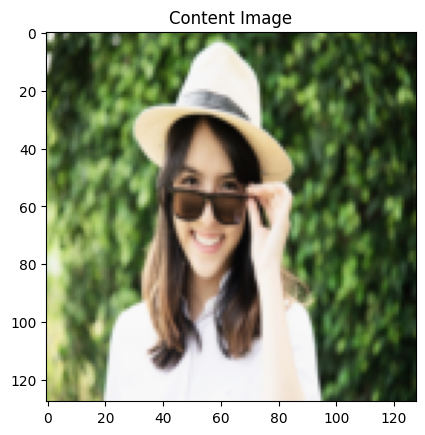

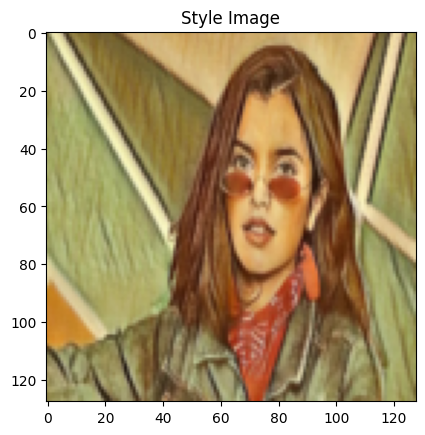

In [3]:
unloader = transforms.ToPILImage()  # Reconvert to PIL image for display

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(style_img, title='Style Image')

In [4]:
cnn = models.vgg19(pretrained=True).features.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 60.5MB/s]


In [5]:
# Normalization for VGG19
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# Content Loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

# Style Loss
def gram_matrix(input):
    batch_size, feature_map, h, w = input.size()
    features = input.view(batch_size * feature_map, h * w)
    G = torch.mm(features, features.t())
    return G.div(batch_size * feature_map * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input


In [8]:
normalization = nn.Sequential(
    transforms.Normalize(cnn_normalization_mean, cnn_normalization_std))

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # Create a new Sequential model
    model = nn.Sequential()
    normalization = transforms.Normalize(normalization_mean, normalization_std)
    model.add_module('normalization', normalization)


    content_losses = []
    style_losses = []


    i = 0  # increment conv layer index
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim after last loss layer
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

Step 50:
Style Loss: 127.501320 Content Loss: 24.134203
Step 100:
Style Loss: 46.981136 Content Loss: 24.824581
Step 150:
Style Loss: 25.351316 Content Loss: 24.204134
Step 200:
Style Loss: 16.314404 Content Loss: 23.291273
Step 250:
Style Loss: 12.086892 Content Loss: 22.232218
Step 300:
Style Loss: 9.836862 Content Loss: 21.373400


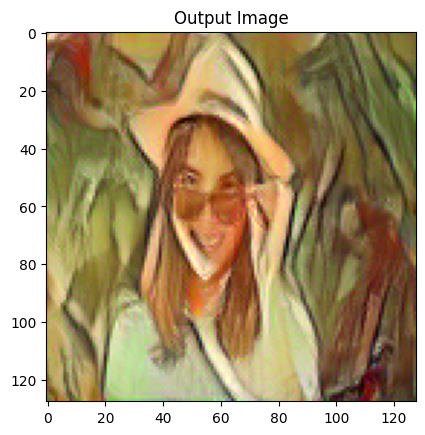

In [9]:
input_img = content_img.clone()

optimizer = optim.LBFGS([input_img.requires_grad_()])

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std, style_img, content_img)

num_steps = 300
style_weight = 1000000
content_weight = 1

run = [0]
while run[0] <= num_steps:

    def closure():
        with torch.no_grad():
            input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}:")
            print(f'Style Loss: {style_score.item():4f} Content Loss: {content_score.item():4f}')

        return style_score + content_score

    optimizer.step(closure)

input_img.data.clamp_(0, 1)

plt.figure()
imshow(input_img, title='Output Image')

# Save output
output = unloader(input_img.squeeze(0))
output.save("output.png")